# BIBLIOTECAS E DATASET

In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import random

import joblib
import datetime
import math

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

from warnings import filterwarnings
filterwarnings('ignore')

In [53]:
# Google Stock Dataset
df = pd.read_csv('GOOG1.csv')

In [54]:
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,37.150002,37.202999,36.562901,37.091999,37.091999,65456000
1,2016-01-05,37.322498,37.599998,36.931999,37.129002,37.129002,39014000
2,2016-01-06,36.500000,37.359001,36.445999,37.181000,37.181000,38940000


# ANÁLISE DOS DADOS

In [55]:
df.shape

(1962, 7)

In [56]:
isNull = df.isnull().sum().to_frame(name='isNull').T
Unique = df.nunique().to_frame(name='Unique').T
summary = pd.concat([Unique, isNull])
summary

,Date,Open,High,Low,Close,Adj Close,Volume
Unique,1962,1914,1937,1934,1937,1937,1890
isNull,0,0,0,0,0,0,0


In [57]:
df.duplicated().sum()

0

In [58]:
df['Date']= pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date')

In [59]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1.962000e+03
mean,77.583771,78.435983,76.802836,77.636289,77.636289,3.102888e+07
std,34.414879,34.838853,34.021956,34.425275,34.425275,1.421140e+07
min,33.392502,33.615002,33.153000,33.412998,33.412998,6.936000e+06
25%,51.120375,51.746500,50.657076,51.159376,51.159376,2.207798e+07
50%,62.630749,63.425251,62.124500,63.057000,63.057000,2.722935e+07
75%,106.080122,107.567749,104.964000,106.120003,106.120003,3.520250e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.269620e+08


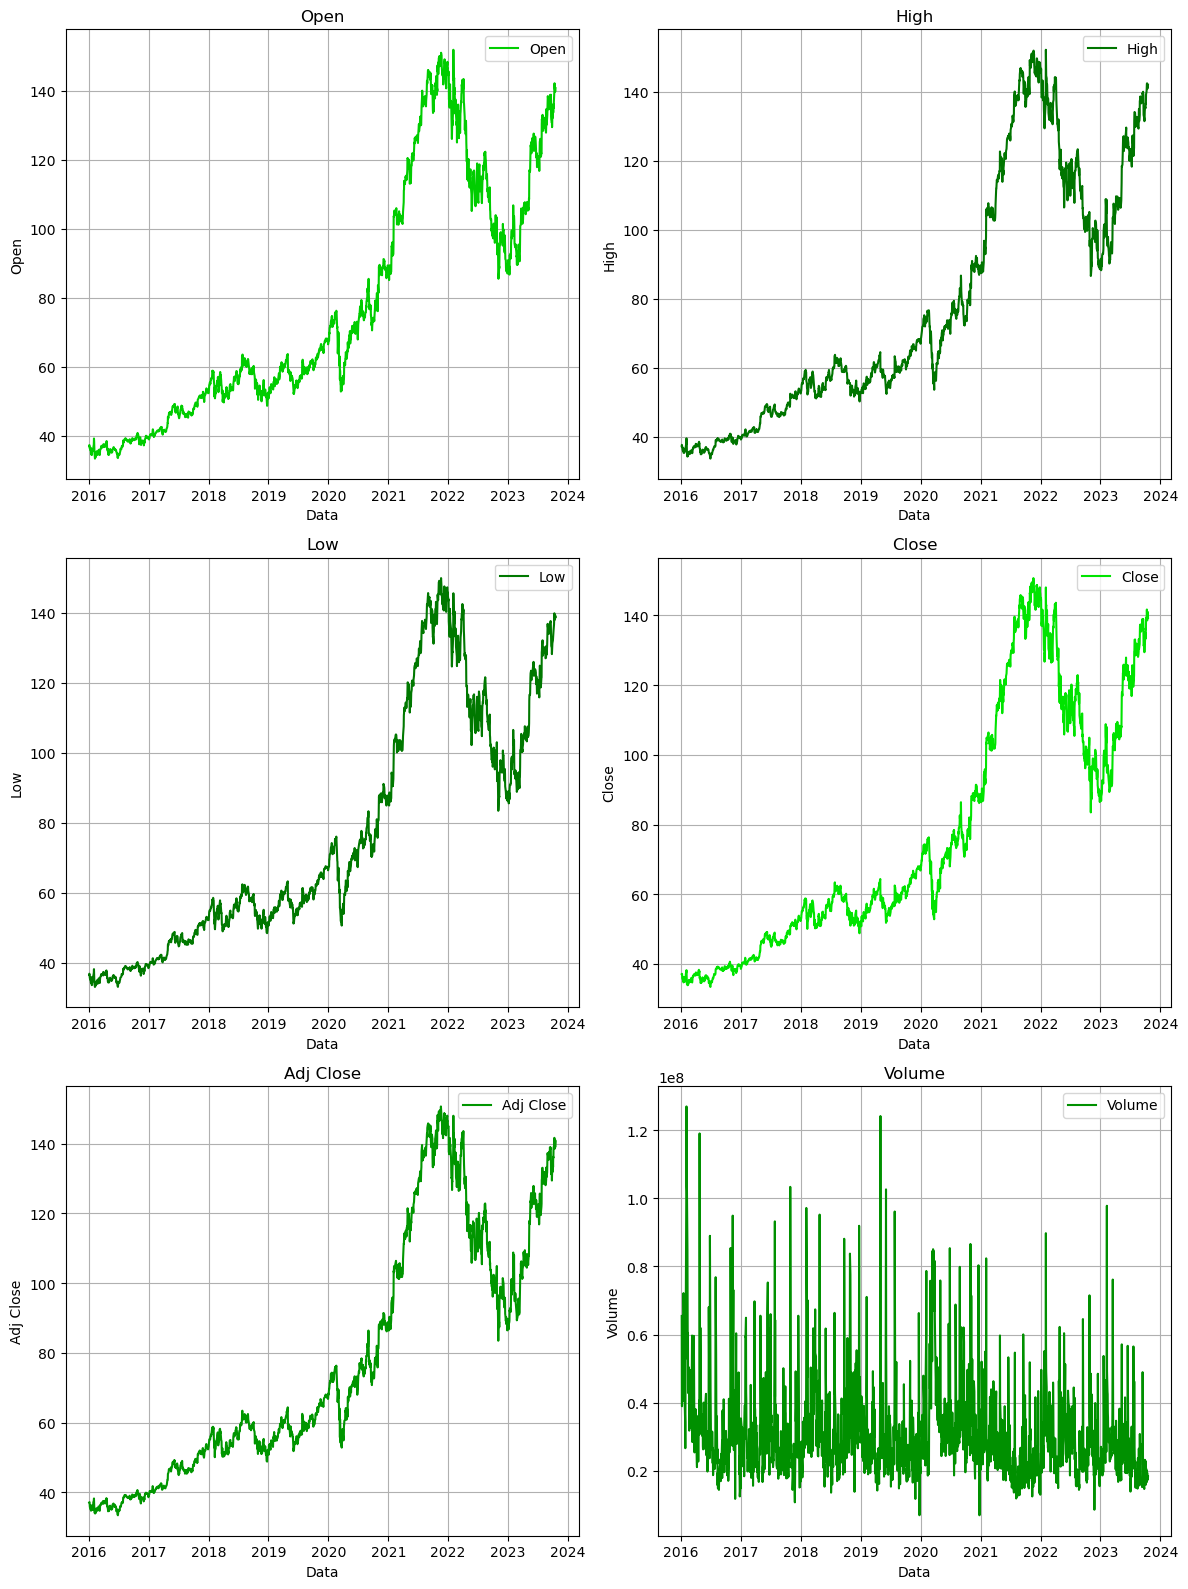

In [60]:
# Plot features de acordo com a data
random_colors = ['#%02X%02X%02X'%(0, random.randint(100, 255), 0) for _ in range(20)]

fig, axs = plt.subplots(len(df.columns)//2, 2, figsize=(12, 16))

for i, column in enumerate(df.columns):
    row = i//2
    col = i%2
    axs[row, col].plot(df.index, df[column], label=column, color=random_colors[i])
    
    axs[row, col].set_xlabel('Data')
    axs[row, col].set_ylabel(column)
    axs[row, col].set_title(column)
    axs[row, col].grid(True)
    
    axs[row, col].legend()

plt.tight_layout()
plt.show()

In [61]:
# Média Móvel
df['Close_MA'] = df['Close'].rolling(window=10).mean()

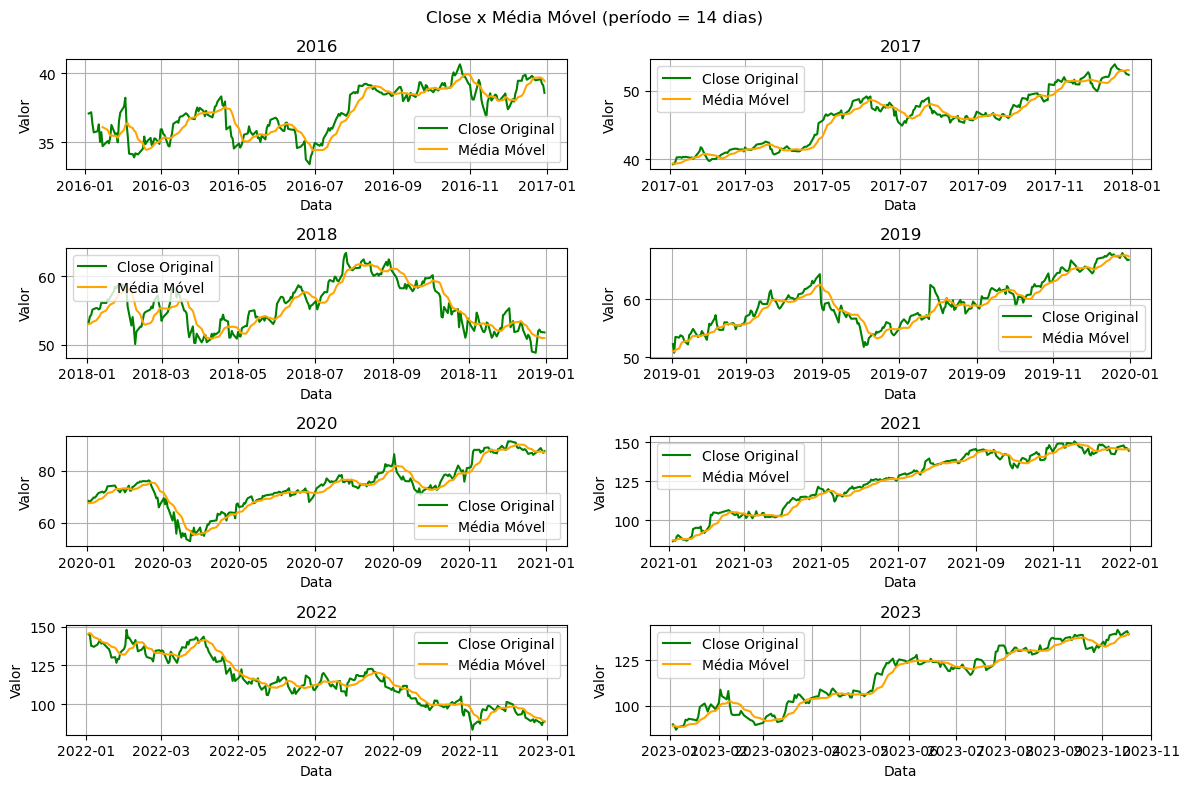

In [62]:
df['Year'] = df.index.year
unique_years = df['Year'].unique()

fig, axes = plt.subplots(4, 2, figsize=(12, 8))
fig.suptitle("Close x Média Móvel (período = 14 dias)")

for i, year in enumerate(unique_years):
    row = i//2
    col = i%2

    subset = df[df['Year'] == year]
    
    axes[row, col].plot(subset.index, subset['Close'], label='Close Original', color='green')
    axes[row, col].plot(subset.index, subset['Close_MA'], label='Média Móvel', color='orange')
    axes[row, col].legend()
    axes[row, col].set_xlabel('Data')
    axes[row, col].set_ylabel('Valor')
    axes[row, col].set_title(f'{year}')
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

In [63]:
df['Lucro Diario'] = df['Close'] - df['Open']

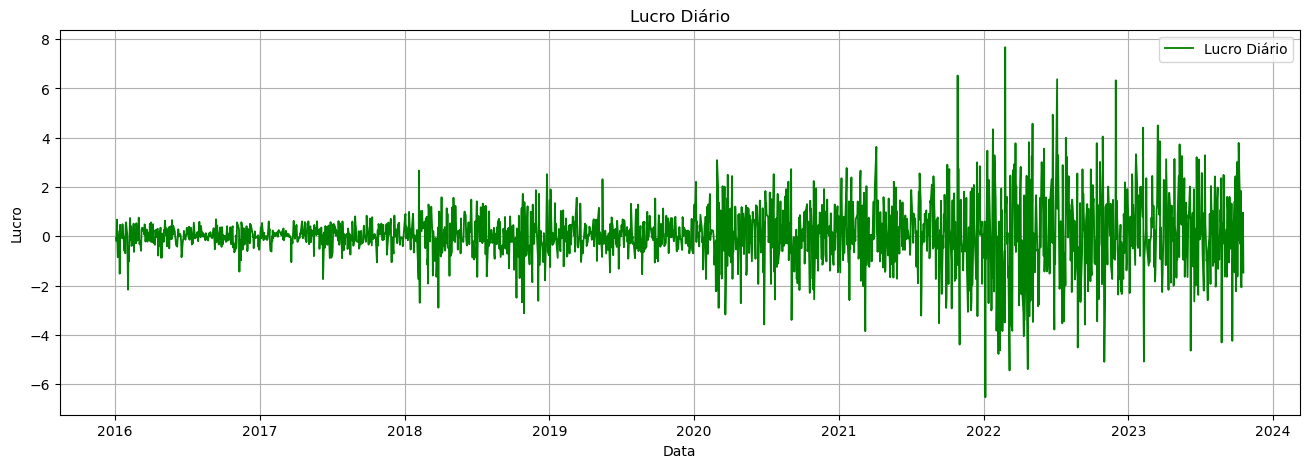

In [64]:
plt.figure(figsize=(16, 5))
plt.plot(df['Lucro Diario'], color='green', linewidth=1.3, label='Lucro Diário')
plt.xlabel('Data')
plt.ylabel('Lucro')
plt.title('Lucro Diário')
plt.legend()
plt.grid(True)

plt.show()

# FUNÇÕES

In [65]:
# Função para preparar os dados de input e output para nosso modelo
def reshape_data(df, time_steps):
    
    X = []
    y = []

    for i in range(time_steps, len(df)):
        X.append(df[i-time_steps:i,0])
        y.append(df[i,0])
        
    return np.array(X), np.array(y)

In [66]:
# Preditar valores futuros com base nos antigos (pegar os útimos x (time_stamps) registros para preditar o próximo)
def predict_values_for_future_dates(model, data, start_date, num_dates, time_steps):
    predictions = []

    current_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    
    for _ in range(num_dates):
        input_data = data[-time_steps:].values
        input_data = input_data.reshape(1, time_steps, 1)
        
        prediction = model.predict(input_data)
        predictions.append(prediction[0, 0])
        
        current_date += datetime.timedelta(days=1)
        
        data = pd.concat([data, pd.DataFrame({'close': prediction[0, 0]}, index=[current_date])])

    return predictions

# CALLBACK

In [67]:
# Callback EarlyStop quando loss repetir 5 vezes seguidas
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

# PRÉ-PROCESSAMENTO

In [68]:
# Tamanho da memória do LSTM
time_steps = 20

In [69]:
data = df.filter(['Close'])

dataset = data.values

training_data_len = math.ceil(len(dataset) * .8)
print(training_data_len)

1570


In [70]:
# Split em treino e teste
train_data = dataset[:training_data_len, :]
test_data = dataset[training_data_len-time_steps:, :]

In [71]:
# Datas de acordo com data dataset (treino e teste)
train_dates = data[:training_data_len].index
test_dates = data[training_data_len-time_steps:].index

In [72]:
print(train_data.shape)
print(test_data.shape)

(1570, 1)
(412, 1)


In [73]:
# MinMaxScaler nos dados de treino e teste
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [74]:
# Split novamente
X_train, y_train = reshape_data(train_data, time_steps)
X_test, y_test = reshape_data(test_data, time_steps)

In [75]:
# Reshape dos dados de X de 2D para 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [76]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1550, 20, 1)
(392, 20, 1)
(1550,)
(392,)


# MODELO (LSTM)

In [77]:
# Modelo LSTM
model = Sequential([
    LSTM(40, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.20),
    LSTM(40, return_sequences=False),
    Dropout(0.20),
    Dense(16),
    Dropout(0.20),
    Dense(1)
])

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_3 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                656       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [79]:
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics = ['mean_absolute_error']
             )

In [80]:
history = model.fit(
    X_train,
    y_train,
    callbacks=early_stop,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
49/49 [==============================] - 5s 18ms/step - loss: 0.0329 - mean_absolute_error: 0.1159
Epoch 2/50
49/49 [==============================] - 1s 17ms/step - loss: 0.0088 - mean_absolute_error: 0.0572
Epoch 3/50
49/49 [==============================] - 1s 18ms/step - loss: 0.0073 - mean_absolute_error: 0.0519
Epoch 4/50
49/49 [==============================] - 1s 17ms/step - loss: 0.0065 - mean_absolute_error: 0.0503
Epoch 5/50
49/49 [==============================] - 1s 17ms/step - loss: 0.0050 - mean_absolute_error: 0.0433
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 0.0044 - mean_absolute_error: 0.0408
Epoch 7/50
49/49 [==============================] - 1s 18ms/step - loss: 0.0046 - mean_absolute_error: 0.0414
Epoch 8/50
49/49 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_absolute_error: 0.0411
Epoch 9/50
49/49 [==============================] - 1s 20ms/step - loss: 0.0044 - mean_absolute_error: 0.0401
Epoch 10/5

In [81]:
# Melhor loss e MAE nos dados de teste
model.evaluate(X_test, y_test)

13/13 [==============================] - 1s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0323


[0.0015265286201611161, 0.03228536248207092]

# VISUALIZAÇÃO DOS RESULTADOS

In [82]:
losses = pd.DataFrame(history.history)
losses.head()

,loss,mean_absolute_error
0,0.032926,0.115932
1,0.008757,0.057235
2,0.007343,0.051879
3,0.006459,0.050332
4,0.004994,0.043287


<Axes: >

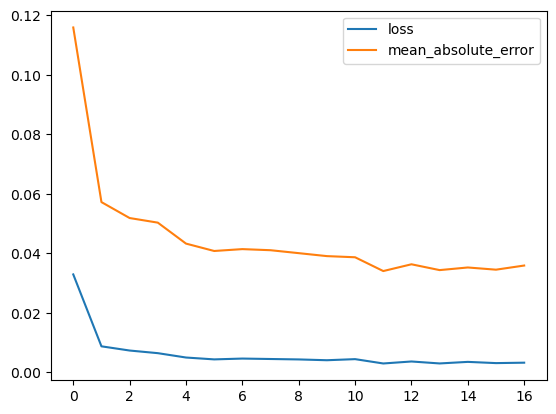

In [83]:
losses[['loss','mean_absolute_error']].plot()

In [84]:
# Passar os dados de treino scaled para not scaled
y_pred_train = model.predict(X_train)
y_pred_train = scaler.inverse_transform(y_pred_train)

y_train_normal = y_train.reshape((y_train.shape[0], -1))
y_train_normal = scaler.inverse_transform(y_train_normal)

49/49 [==============================] - 1s 9ms/step


In [85]:
# model.predict(X_test[-1].reshape(1, X_test.shape[1], 1))[0][0]

In [86]:
# Passar os dados de teste scaled para not scaled
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

y_test_normal = y_test.reshape((y_test.shape[0], -1))
y_test_normal = scaler.inverse_transform(y_test_normal)

13/13 [==============================] - 0s 7ms/step


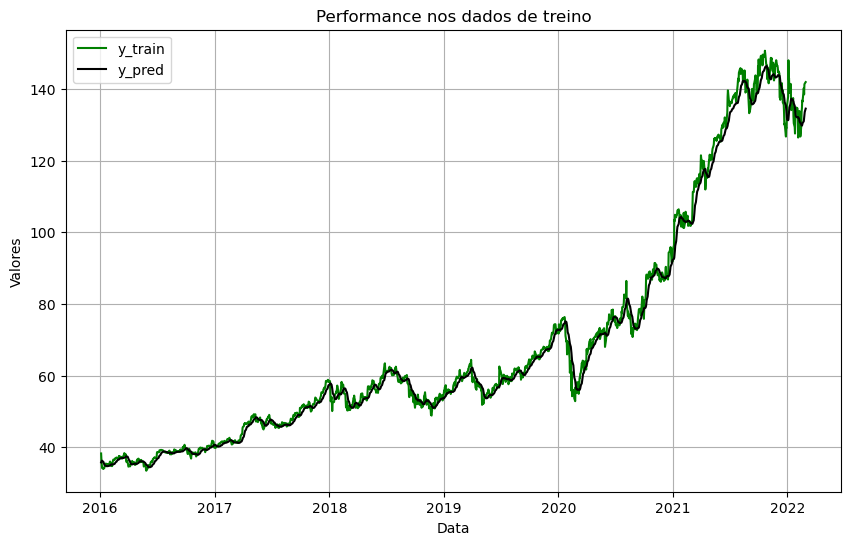

In [87]:
# Performance nos dados de treino
plt.figure(figsize=(10, 6))
plt.plot(train_dates[:y_train_normal.shape[0]], y_train_normal, label='y_train', color='green')
plt.plot(train_dates[:y_pred_train.shape[0]], y_pred_train, label='y_pred', color='black')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Performance nos dados de treino')
plt.legend()
plt.grid()
plt.show()

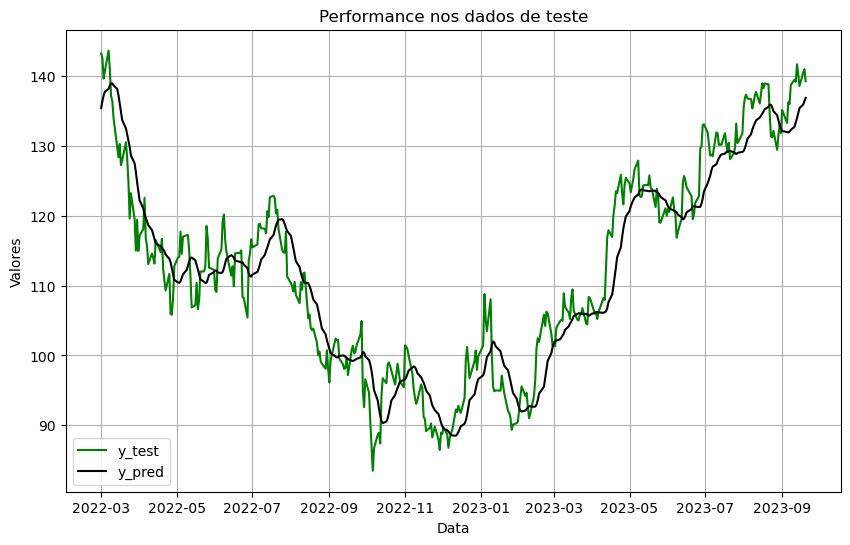

In [88]:
# Performance nos dados de teste
plt.figure(figsize=(10, 6))
plt.plot(test_dates[:y_test_normal.shape[0]], y_test_normal, label='y_test', color='green')
plt.plot(test_dates[:y_pred_test.shape[0]], y_pred_test, label='y_pred', color='black')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Performance nos dados de teste')
plt.legend()
plt.grid()
plt.show()

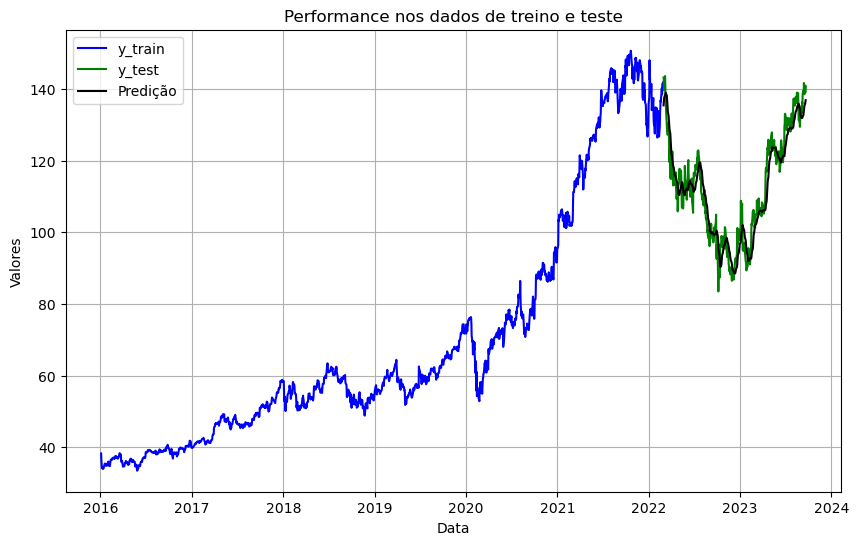

In [89]:
# Plot do gráfico final com os resultados
plt.figure(figsize=(10, 6))
plt.plot(train_dates[:y_train_normal.shape[0]], y_train_normal, label='y_train', color='blue')
plt.plot(test_dates[:y_test_normal.shape[0]], y_test_normal, label='y_test', color='green')
plt.plot(test_dates[:y_pred_test.shape[0]], y_pred_test, label='Predição', color='black')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Performance nos dados de treino e teste')
plt.legend()
plt.grid()
plt.show()

# FORECASTING

In [90]:
# Adicionar os resultados passados em um Dataframe novo
last_results = pd.DataFrame({'close': data.values.reshape(-1, )}, index=data.index)

In [91]:
last_results['close'] = scaler.transform(last_results['close'].values.reshape(-1, 1))

In [92]:
# Preditando 500 dias para frente
start_date = data.index[-1].date().strftime('%Y-%m-%d')
# start_date = '2021-06-11'

num_dates = 500

predicted_values = predict_values_for_future_dates(model, last_results, start_date, num_dates+1, time_steps)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


In [93]:
NEW_DATES = [data.index[-1]]

for _ in range(num_dates):
    NEW_DATES.append(data.index[-1] + pd.DateOffset(days=_+1))

In [94]:
RESULTS = pd.DataFrame({'close': predicted_values[:]}, index=NEW_DATES)

In [95]:
# Deixar nossos resultados na escala normal
RESULTS['close'] = scaler.inverse_transform(RESULTS[['close']])

In [96]:
RESULTS.tail()

,close
2025-02-25,99.546524
2025-02-26,99.516510
2025-02-27,99.486580
2025-02-28,99.456688
2025-03-01,99.426857


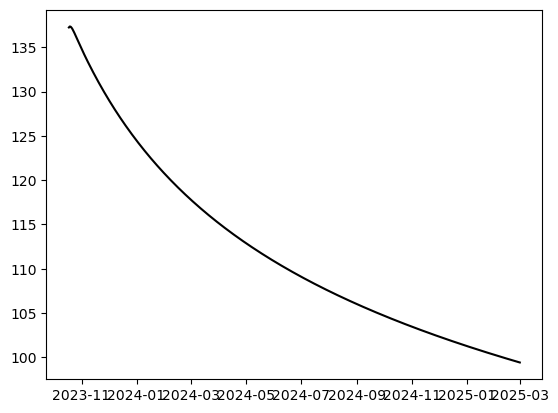

In [97]:
# Gráfico dos norros rsultados futuros
plt.plot(RESULTS.index, RESULTS['close'], label='Predição', color='black')

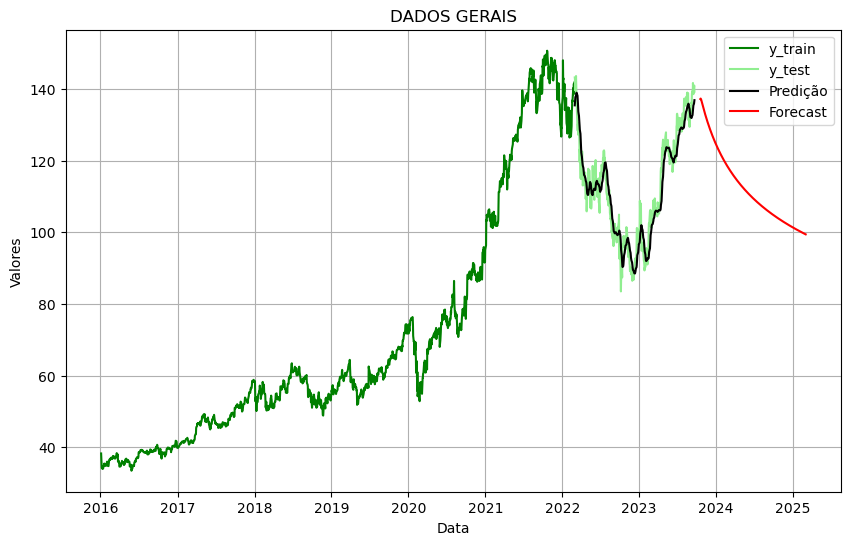

In [98]:
# Plot do gráfico final com os resultados
plt.figure(figsize=(10, 6))
plt.plot(train_dates[:y_train_normal.shape[0]], y_train_normal, label='y_train', color='green')
plt.plot(test_dates[:y_test_normal.shape[0]], y_test_normal, label='y_test', color='lightgreen')
plt.plot(test_dates[:y_pred_test.shape[0]], y_pred_test, label='Predição', color='black')
plt.plot(RESULTS.index, RESULTS['close'], label='Forecast', color='red')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('DADOS GERAIS')
plt.legend()
plt.grid()
plt.show()

# EXPORTAÇÃO DO MODELO

In [99]:
model.save("lstm_model.h5") # salvando o modelo

In [100]:
joblib.dump(scaler, 'scaler.pkl') # salvando o scaler

['scaler.pkl']